In [30]:
import datetime
import time
from statistics import mean
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np


DATE_FORMAT = '%Y-%m-%d %H:%M:%S'


def string_to_timestamp(date_string):#convert time string to float value
    time_stamp = time.strptime(date_string, DATE_FORMAT)
    return time.mktime(time_stamp)


def aggregate(before_aggregate, aggregate_feature):
    if aggregate_feature == 'day':
        pos_date = -1
        before_aggregate.sort(key=itemgetter(pos_date))
        t = groupby(before_aggregate, itemgetter(pos_date))
        
    
    elif aggregate_feature == 'client':
        pos_client = -3
        before_aggregate.sort(key=itemgetter(pos_client))
        t = groupby(before_aggregate, itemgetter(pos_client))
        
#     elif aggregate_feature == 'country':
#         pos_country = 
    
    res = []
    for i, e in t:
        res.append([i, list(e)])
    return res


In [4]:
src = '/home/cas/Workspace/CDA_CS4035/Week 1 - Credit Card Fraud/assignment-data/data_for_student_case.csv'
ah = open(src, 'r')
x = []#contains features
y = []#contains labels
data = []
color = []
(issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in range(10)]
(issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in range(10)]
#label_set
#cvcresponse_set = set()
ah.readline()#skip first line
for line_ah in ah:
    if line_ah.strip().split(',')[9]=='Refused':# remove the row with 'refused' label, since it's uncertain about fraud
        continue
    if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
        continue
    bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])# date reported flaud
    issuercountry = line_ah.strip().split(',')[2]#country code
    issuercountry_set.add(issuercountry)
    txvariantcode = line_ah.strip().split(',')[3]#type of card: visa/master
    txvariantcode_set.add(txvariantcode)
    issuer_id = float(line_ah.strip().split(',')[4])#bin card issuer identifier
    amount = float(line_ah.strip().split(',')[5])#transaction amount in minor units
    currencycode = line_ah.strip().split(',')[6]
    currencycode_set.add(currencycode)
    shoppercountry = line_ah.strip().split(',')[7]#country code
    shoppercountry_set.add(shoppercountry)
    interaction = line_ah.strip().split(',')[8]#online transaction or subscription
    interaction_set.add(interaction)
    if line_ah.strip().split(',')[9] == 'Chargeback':
        label = 1#label fraud
    else:
        label = 0#label save
        
    verification = line_ah.strip().split(',')[10]#shopper provide CVC code or not
    verification_set.add(verification)
    cvcresponse = line_ah.strip().split(',')[11]#0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
    if int(cvcresponse) > 2:
        cvcresponse = 3
    year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12], DATE_FORMAT).year
    month_info = '%02d' % datetime.datetime.strptime(line_ah.strip().split(',')[12], DATE_FORMAT).month
    day_info = '%02d' % datetime.datetime.strptime(line_ah.strip().split(',')[12], DATE_FORMAT).day
    creationdate = str(year_info)+'-'+str(month_info)+'-'+str(day_info)#Date of transaction 
    creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])#Date of transaction-time stamp
    accountcode = line_ah.strip().split(',')[13]#merchant’s webshop
    accountcode_set.add(accountcode)
    mail_id = int(float(line_ah.strip().split(',')[14].replace('email','')))#mail
    mail_id_set.add(mail_id)
    ip_id = int(float(line_ah.strip().split(',')[15].replace('ip','')))#ip
    ip_id_set.add(ip_id)
    card_id = int(float(line_ah.strip().split(',')[16].replace('card','')))#card
    card_id_set.add(card_id)
    data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                 accountcode, mail_id, ip_id, card_id, label, creationdate])# add the interested features here
    y.append(label)# add the labels
    

In [5]:
# data = sorted(data, key=lambda e: e[-1])
fraud_data = [d for d in data if d[-2] == 1]
benign_data = [d for d in data if d[-2] == 0]

1924


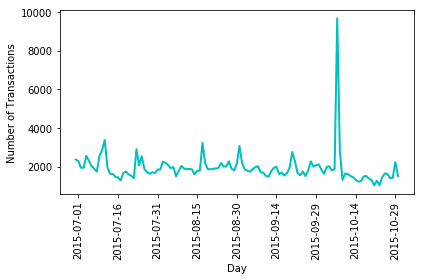

In [28]:
day_aggregate = aggregate(data, 'day')
number_of_days = len(day_aggregate)
day_num = [len(l) for _, l in day_aggregate]
print(round(mean(day_num)))
labels = [e for e, _ in day_aggregate][0:number_of_days:15]
x_label_locations = [i for i in range(1, number_of_days+1)][0:number_of_days:15]

plt.figure(0)
plt.plot(day_num, color = 'c', linewidth = 2)
plt.xticks(x_label_locations, labels, rotation='vertical')

plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.tight_layout()
# plt.axis('tight')
plt.savefig('Transactions per day.png')

In [14]:
# Find out in which percentage the CVC was not supplied for a data set
supplied = 0
not_supplied = 0
# Adjust to benign_data for the benign transactions.
for row in benign_data:
    if row[7].lower() == "true":
        supplied += 1
    else:
        not_supplied += 1
        
print(f"Supplied: {supplied}")
print(f"Not supplied: {not_supplied}")
print("The percentage of transations for which the CVC was not supplied is:", not_supplied/(supplied+not_supplied))

Supplied: 216261
Not supplied: 20092
The percentage of transations for which the CVC was not supplied is: 0.08500844076444979


In [ ]:
fraud_aggregate = aggregate(fraud_data,'client')
print(fraud_aggregate)
fraud_num_client = [len(l) for l in fraud_aggregate]
print(mean(fraud_num_client))

plt.figure(1)
plt.plot(fraud_num_client, color = 'c', linewidth = 2)
plt.xlabel('Client ID')
plt.ylabel('Number of Transactions')
plt.axis('tight')
plt.savefig('Fraudulent per client.png')

client_aggregate = aggregate(benign_data,'client')
transaction_num_client = [len(l) for l in client_aggregate]
    
plt.figure(2)
plt.plot(transaction_num_client, color = 'c', linewidth = 2)
#plt.text(99,9668,'Date: 2015-10-8')
plt.xlabel('Client ID')
plt.ylabel('Number of Transactions')
plt.axis('tight')
plt.savefig('Benign per client.png')

In [5]:

for item in data:#split data into x,y
    x.append(item[0:-2])
    y.append(item[-2])
'''map number to each categorial feature'''
for item in list(issuercountry_set):
    issuercountry_dict[item] = list(issuercountry_set).index(item)
for item in list(txvariantcode_set):
    txvariantcode_dict[item] = list(txvariantcode_set).index(item)
for item in list(currencycode_set):
    currencycode_dict[item] = list(currencycode_set).index(item)
for item in list(shoppercountry_set):
    shoppercountry_dict[item] = list(shoppercountry_set).index(item)
for item in list(interaction_set):
    interaction_dict[item] = list(interaction_set).index(item)
for item in list(verification_set):
    verification_dict[item] = list(verification_set).index(item)
for item in list(accountcode_set):
    accountcode_dict[item] = list(accountcode_set).index(item)
print(len(list(card_id_set)))
#for item in list(card_id_set):
#    card_id_dict[item] = list(card_id_set).index(item)
'''modify categorial feature to number in data set'''
for item in x:
    item[0] = issuercountry_dict[item[0]]
    item[1] = txvariantcode_dict[item[1]]
    item[4] = currencycode_dict[item[4]]
    item[5] = shoppercountry_dict[item[5]]
    item[6] = interaction_dict[item[6]]
    item[7] = verification_dict[item[7]]
    item[10] = accountcode_dict[item[10]]

#x_mean = []
#x_mean = aggregate_mean(x);
x_mean = x;
des = '/Users/Qlin/Documents/TA/fraud_credit_card/original_data.csv'
des1 = '/Users/Qlin/Documents/TA/fraud_credit_card/aggregate_data.csv'
ch_dfa = open(des,'w')
#ch_dfa.write('txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,'+
#             'currencycode,shoppercountrycode,shopperinteraction,simple_journal,'+
 #            'cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id')
#ch_dfa.write('\n')
sentence = []
for i in range(len(x_mean)):
    for j in range(len(x_mean[i])):
        sentence.append(str(x_mean[i][j]))
    sentence.append(str(y[i]))
    ch_dfa.write(' '.join(sentence))
    ch_dfa.write('\n')
    sentence=[]
    ch_dfa.flush()    
TP, FP, FN, TN = 0, 0, 0, 0
x_array = np.array(x)
y_array = np.array(y)
usx = x_array
usy = y_array
x_train, x_test, y_train, y_test = train_test_split(usx, usy, test_size = 0.2)#test_size: proportion of train/test data
clf = neighbors.KNeighborsClassifier(algorithm = 'kd_tree')
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
for i in range(len(y_predict)):
    if y_test[i]==1 and y_predict[i]==1:
        TP += 1
    if y_test[i]==0 and y_predict[i]==1:
        FP += 1
    if y_test[i]==1 and y_predict[i]==0:
        FN += 1
    if y_test[i]==0 and y_predict[i]==0:
        TN += 1
print('TP: '+ str(TP))
print('FP: '+ str(FP))
print('FN: '+ str(FN))
print('TN: '+ str(TN))
#print confusion_matrix(y_test, answear) watch out the element in confusion matrix
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
predict_proba = clf.predict_proba(x_test)#the probability of each smple labelled to positive or negative


210542


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Qlin/Documents/TA/fraud_credit_card/original_data.csv'